# EXTENDED FIGURE 5

In [1]:
#plot skeletons of neurons

%load_ext autoreload
%autoreload 2
import skeleton_plot as skelplot
from skeleton_plot.skel_io import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline

In [2]:
skel_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/'


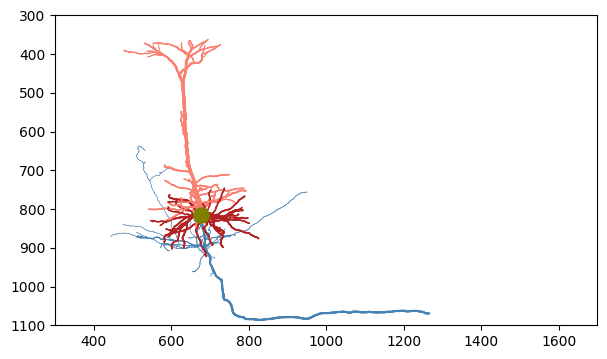

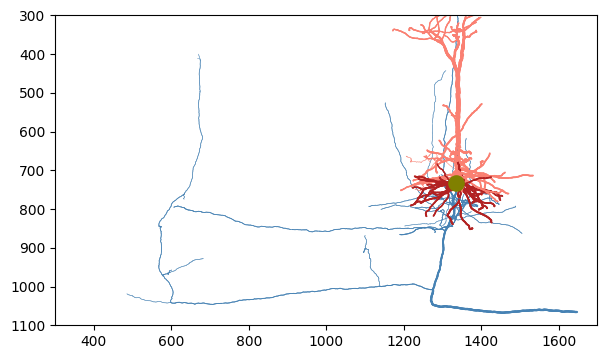

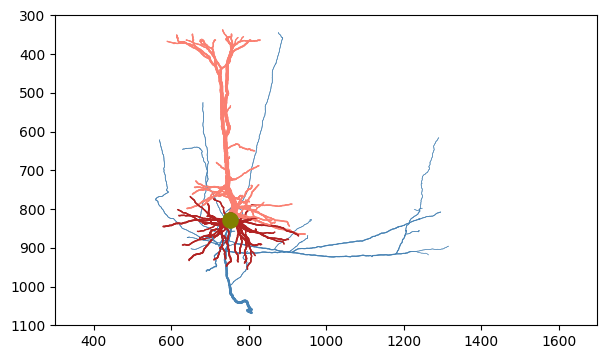

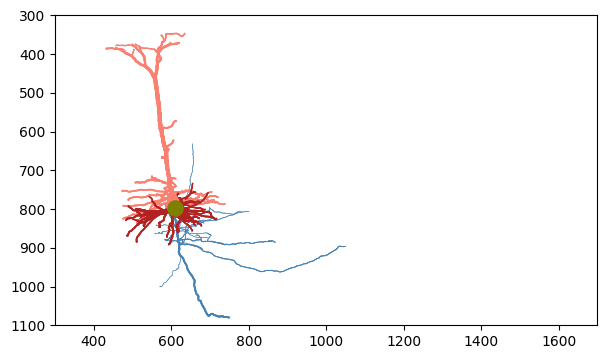

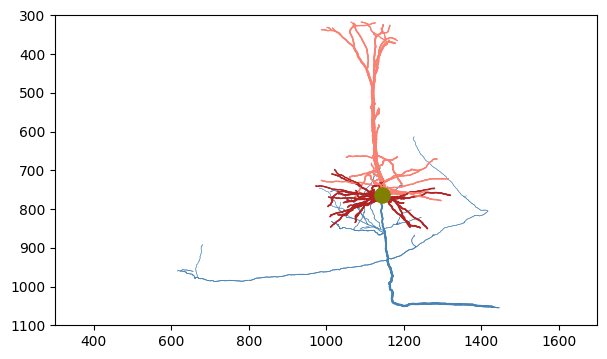

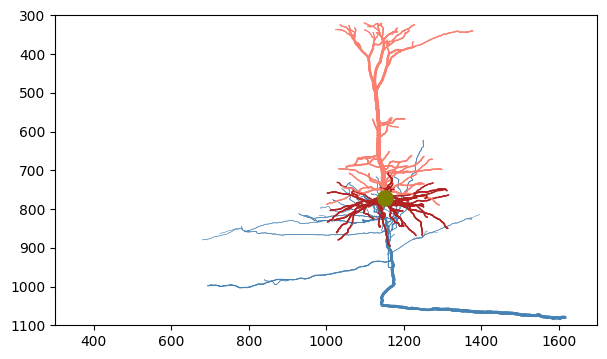

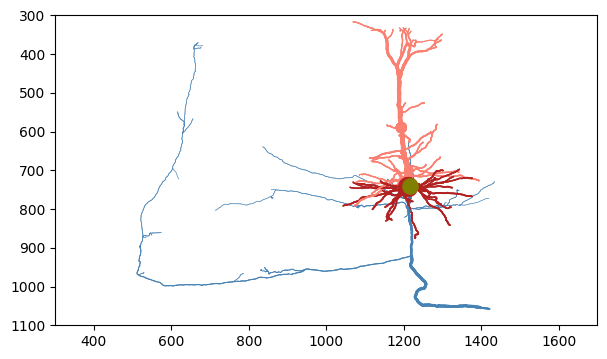

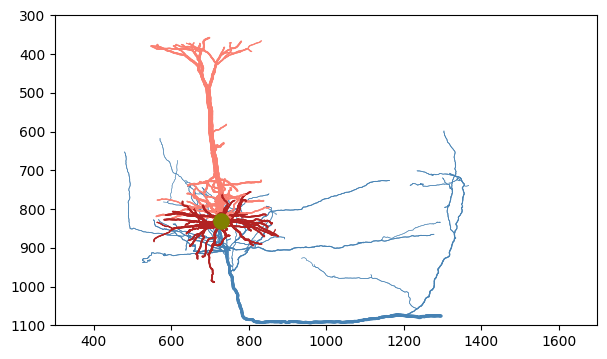

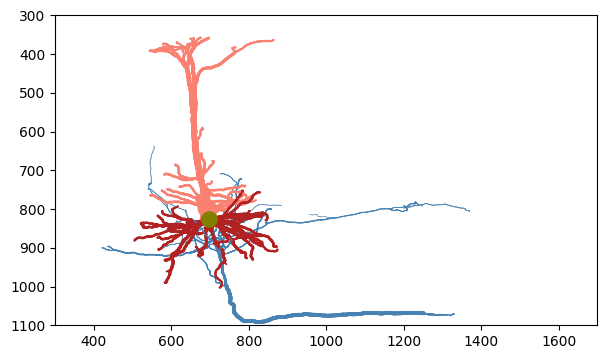

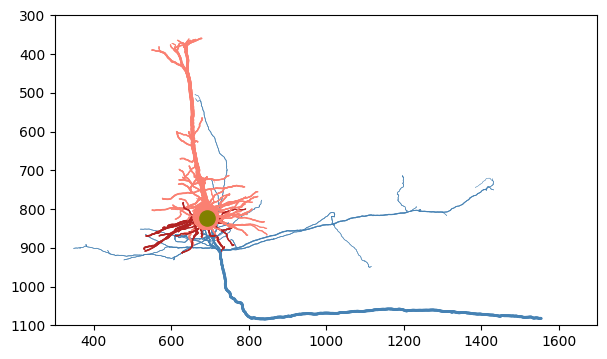

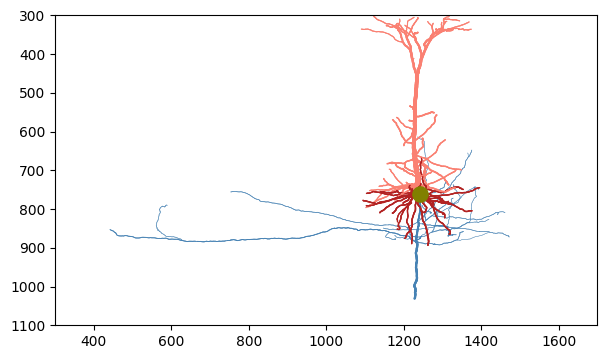

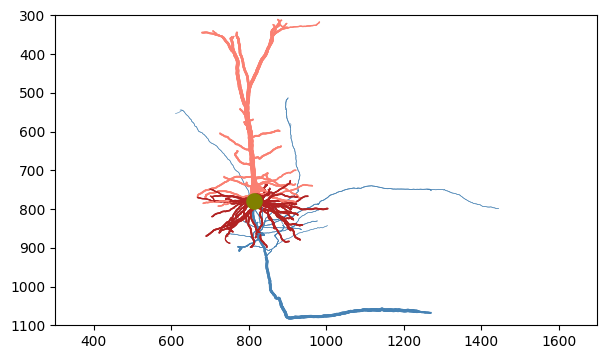

In [3]:
ET_extended =  {'rid': [864691135730543289, 864691136617461979, 864691135182092034, 864691135776144045, 
                        864691135494401680, 864691135472306482, 864691135660737776, 864691135476398504,
                        864691135509054217, 864691135991773633, 864691135850843335, 864691135502157405],
        'sid': [ 266839, 589294, 303216, 232635, 494888, 495010, 526436, 302951, 267033, 267029, 527784,
                337966]}

ET_extended_df = pd.DataFrame(ET_extended)

for _, row in ET_extended_df.iterrows():
    #print(row.sid)

    # plot the radius from the swc 
    rid = row.rid
    sid = row.sid
    sk = read_skeleton(skel_path+f'{rid}_{sid}', f'{rid}_{sid}.swc')

    f , ax = plt.subplots(figsize=(7,10))
    
    skelplot.plot_tools.plot_skel(sk,  ax=ax, pull_radius = True, pull_compartment_colors = True,
                                  invert_y=True, plot_soma = True, 
                                 line_width = 3, color = 'darkslategray') 
    
    ax.set(xlim=(300, 1700), ylim=(1100, 300))
    
    fig_name = 'skeleton' + str(row.sid) + '.eps'
    
    #plt.axis('off')
    
    f.savefig(fig_name, bbox_inches='tight')

